## 1. Set up communication with the FR3

### 1.1 Set up communication with the arm

In [1]:
%load_ext autoreload
%autoreload 2
import time
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
# Print the arm state
robot.getJointStates()

{'q': array([-1.31663911e-04, -7.84861398e-01,  5.81618671e-04, -2.35729207e+00,
        -6.46614281e-04,  1.57008722e+00,  7.85855250e-01]),
 'dq': array([-3.78974477e-04, -1.34185768e-03, -9.35292398e-04,  1.16072953e-03,
         6.22439100e-05, -7.61415463e-04, -1.55196379e-03]),
 'T': array([ 0.14211726, -4.32183981, -0.97792661, 23.52817154,  1.21141279,
         2.59275031, -0.16248104]),
 'M': array([[ 4.83705150e-01, -1.01732528e-02,  4.80955066e-01,
         -1.21770954e-02,  5.55357749e-02, -3.84482024e-03,
          1.56856510e-03],
        [-1.01732528e-02,  1.53640024e+00,  5.02178821e-03,
         -6.90002999e-01, -1.43300451e-02, -2.36978198e-02,
         -6.79806062e-04],
        [ 4.80955066e-01,  5.02178821e-03,  9.84018992e-01,
         -2.77193901e-02,  6.82429665e-02, -4.62336858e-03,
          3.48800803e-03],
        [-1.21770954e-02, -6.90002999e-01, -2.77193901e-02,
          9.50884078e-01,  2.77372252e-02,  1.05992138e-01,
          3.15426477e-04],
        

### 1.2 Set up communication with the gripper

In [ ]:
# from fr3_gripper import Gripper, GripperState
# gripper = Gripper("192.168.123.250")

# Initialize the gripper
# gripper.homing()

# # Print the gripper state
# gripper_state = gripper.readOnce()
# print(gripper_state)

## 2. Define robot task parameters

### 2.1 Load PinocchioModel and define various parameters

In [3]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
torque_lb = np.array([-87, -87, -87, -87, -12, -12, -12])
torque_ub = np.array([87, 87, 87, 87, 12, 12, 12])
joint_acc_lb = np.array([-10, -10, -10, -10, -10, -10, -10])
joint_acc_ub = np.array([10, 10, 10, 10, 10, 10, 10])
v_EE_lb = np.array([-0.2, -0.2, -0.2])
v_EE_ub = np.array([0.2, 0.2, 0.2])
static_friction = np.array([0.8, 2.35, 0.5, 2.35, 1.3, 1.0, 0.5])

n_joints = 7
n_controls = 7
q_bar = 0.5*(joint_ub + joint_lb)
delta_M = np.diag([0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2])

In [4]:
from scipy.spatial.transform import Rotation
from liegroups import SO3
from cores.utils.rotation_utils import get_quat_from_rot_matrix

## 5. Control the arm to pre-cleaning pose

In [5]:
# Define tracking gains
K_p_pos = 1*np.diag([1,1,1])

K_p_rot = 1*np.diag([1,1,1])

Kp_joint = 0.1*np.diag([1, 1, 1, 1, 1, 1, 1])

In [9]:
from cores.utils.trajectory_utils import PositionTrapezoidalTrajectory, OrientationTrapezoidalTrajectory
t_1 = 6
t_final = 10

# Get current pose
robot_info = robot.getJointStates()
q = robot_info['q'] # shape (7,)
dq = robot_info['dq'] # shape (7,)

q_pin = 0.30*np.ones(9)
dq_pin = np.zeros(9)
q_pin[0:n_joints] = q # shape (9,)
dq_pin[0:n_joints] = dq # shape (9,)

pin_info = pin_robot.getInfo(q_pin, dq_pin)
P_EE = pin_info["P_EE"]
R_EE = pin_info["R_EE"]

# Translational trajectory
P_EE_start = P_EE.copy()
P_EE_pre_grasping = np.array([0.5, 0.5, 0.1])
P_EE_end = np.array([0.5, 0.5, 0.4])

via_points = np.array([P_EE_start, P_EE_pre_grasping, P_EE_end])
target_time = np.array([0, t_1, t_final])
Ts = 0.002
traj_position = PositionTrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=Ts)

# Rotational trajectory
R_EE_start  = R_EE.copy()

roll = np.pi
pitch = 0
yaw = 0
R_EE_pre_grasping = Rotation.from_euler('xyz', [roll, pitch, yaw]).as_matrix()

orientations = np.array([R_EE_start, R_EE_pre_grasping])
target_time = np.array([0, t_final])
traj_orientation = OrientationTrapezoidalTrajectory(orientations, target_time, Ts=Ts)

dq_desired_list = []
time_list = []

t_start = time.time()
while time.time() - t_start < t_final + 1:
    t_loop_start = time.time()
    t = time.time() - t_start
    traj_pos, traj_pos_dt, traj_pos_dtdt = traj_position.get_traj_and_ders(t)
    traj_ori, traj_ori_dt, traj_ori_dtdt = traj_orientation.get_traj_and_ders(t)

    robot_info = robot.getJointStates()
    q = robot_info['q'] # shape (7,)
    dq = robot_info['dq'] # shape (7,)

    q_pin = 0.025*np.ones(9)
    dq_pin = np.zeros(9)
    q_pin[0:n_joints] = q # shape (9,)
    dq_pin[0:n_joints] = dq # shape (9,)

    pin_info = pin_robot.getInfo(q_pin, dq_pin)

    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    v_EE = J_EE @ dq # shape (6,)2

    # Primary obejctive: tracking control
    e_pos = P_EE - traj_pos # shape (3,)
    v_desired = traj_pos_dt - K_p_pos @ e_pos

    e_rot = SO3(R_EE @ traj_ori.T).log() # shape (3,)
    omega_desired = traj_ori_dt -K_p_rot @ e_rot

    v_EE_desired = np.concatenate([v_desired, omega_desired])
    S = J_EE
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = (np.eye(len(q)) - S_pinv @ S)
    dq_task = S_pinv @ v_EE_desired

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    q_bar = 1/2*(joint_ub+joint_lb)
    e_joint = W @ (q - q_bar)
    dq_desired = dq_task + S_null @ (- Kp_joint @ e_joint)

    robot.setCommands(dq_desired)
    dq_desired_list.append(dq_desired.copy())
    time_list.append(t)

robot.setCommands(np.zeros_like(dq_desired))


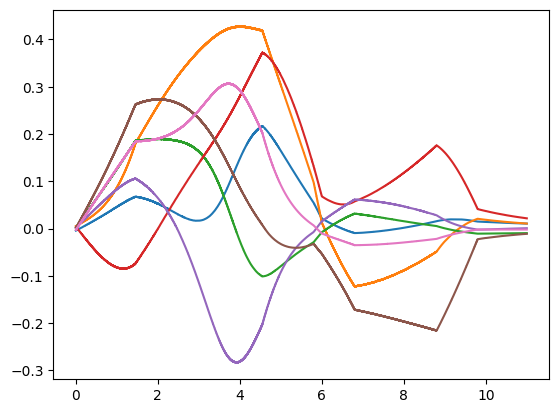

In [8]:
import matplotlib.pyplot as plt
time_list = np.array(time_list)
dq_desired_list = np.array(dq_desired_list)
plt.plot(time_list, dq_desired_list)